In [7]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
from torch_geometric.data import Data
from net import SegmentationNet, WrapSegmentationNet
from net import ClassifierNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('/data/rradev/supernovae_trigger/outputs/wrapper_net_epoch3_acc_0.93.pth')
model = WrapSegmentationNet(100, 2, 2).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
pos = torch.randn(100, 7)
node_label = torch.randn(100)
label = torch.randn(100)
batch = Data(
    x=node_label,
    y=label,
    pos=pos.to(torch.float)).to(device)

model.eval()

WrapSegmentationNet(
  (segmentation_network): SegmentationNet(
    (conv1): DynamicEdgeConv(nn=MLP(14, 64, 64), k=30)
    (conv2): DynamicEdgeConv(nn=MLP(128, 64, 64), k=30)
    (conv3): DynamicEdgeConv(nn=MLP(128, 64, 64), k=30)
    (mlp): MLP(192, 1024, 256, 128, 2)
  )
  (mlp): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [12]:
def split_string(string): 
    return float(string.split(":,",1)[1][:])

def detach_tensor(tensor):
    return tensor.cpu().detach().numpy()

def parse_log(logfile):
    train_acc = []
    test_acc = []
    with open(logfile) as f:
        lines = f.readlines()


    for line in lines:
        if 'Current train acc:' in line:
            train_acc.append(split_string(line))
        if 'Current test acc' in line:
            test_acc.append(split_string(line))
    return train_acc, test_acc

def plot_metric(metric, label):
    plt.plot(np.arange(len(metric)), metric, label=label)
    
    
def plot_logfile(logfile, training_label=''):
    train_acc, test_acc = parse_log(logfile)
    plot_metric(train_acc, label=f'{training_label}_train')
    plot_metric(test_acc, label=f'{training_label}_test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


In [3]:
# plt.rcParams['figure.figsize'] = (8, 4)
# log_folder = '/data/rradev/supernovae_trigger/log/'
# logfile = 'segment_2022-11-22_16-18-14_296928.log'

# plot_logfile(log_folder + logfile, '100hits')
# plt.legend()


### Compute Classification Report

In [8]:
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from math import floor
from tqdm import tqdm
from dataset import HitsDataset

batch_size = 32
ds = HitsDataset(per_event_shuffle=True)
train_len = floor(0.8 * len(ds))
test_len = len(ds) - train_len
generator=torch.Generator().manual_seed(42)
train_ds, test_ds = random_split(ds, lengths=[train_len, test_len], generator=generator)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
del train_ds

Fit Scaler, now transforming ...


/data/rradev/supernovae_trigger/dataset.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = scaler.transform(torch.tensor(data))


In [25]:
batch = next(iter(test_ds))

In [9]:
# import seaborn as sns

# n_hits = []
# for item in test_ds:
#     node_label = item['x']
#     class_label = item['y']
#     if class_label == 1:
#         n_hits.append(torch.sum(node_label == 1).item())

# sns.histplot(n_hits, discrete=True)

In [9]:
def test(loader):
    preds = []
    labels = []
    node_labels = []
    model.eval()
    for data in tqdm(loader):
        data = data.to(device)
        with torch.no_grad():
            pred = model(data, batch_size)
        if data.y.shape[0] == batch_size:
            preds.append(pred)
            labels.append(data.x)
            node_labels.append(torch.sum(data.x.view(batch_size, -1), axis=1))
    return detach_tensor(torch.vstack(preds)), np.argmax(detach_tensor(torch.vstack(preds)), axis=1), detach_tensor(torch.hstack(labels)), detach_tensor(torch.hstack(node_labels))

probas, preds, labels, node_labels = test(test_loader)

  0%|          | 0/894 [00:00<?, ?it/s]


TypeError: WrapSegmentationNet.forward() missing 1 required positional argument: 'bath_size'

In [13]:
prediction = []
true_class = []
for batch in test_loader:
    with torch.no_grad():
        pred  = model(batch.to(device))

    predicted_class = []
    for i in range(batch_size):
        predictions = pred[batch['batch'] == i].argmax(dim=-1)
        if torch.sum(predictions) >= 10:
            predicted_class.append(1)
        else:
            predicted_class.append(0)
    
    predicted_class = torch.tensor(predicted_class)
    prediction.append(predicted_class)
    true_class.append(batch['y'])


In [14]:
preds = torch.hstack(prediction[:-1])
trues = torch.hstack(true_class[:-1])

torch.sum(preds == trues.cpu())/len(preds)

tensor(0.9065)

In [45]:
iterator = iter(test_ds)

tensor(99, device='cuda:0')

In [173]:
import torch.nn.functional as F

torch.exp(model(batch)[:, 1]).mean()

tensor(0.2173, device='cuda:0', grad_fn=<MeanBackward0>)

In [733]:
proba = []
y_true = []
for i in range(1000):
    batch = next(iterator)
    pred_scores = model(batch.to(device))
    pred_nodes = pred_scores.argmax(dim=-1).to(float)
    pos_probas = torch.sum(torch.exp(pred_scores[:, 0])[pred_nodes == 1])
    pos_nodes = torch.sum(pred_nodes)
    negative_nodes = 100 - pos_nodes
    neg_probas = torch.sum(torch.exp(pred_scores[:, 0])[pred_nodes == 0])
    n_neg_examples = torch.sum(pred_nodes == 0)
    n_pos_examples = torch.sum(pred_nodes == 1)
    probas = (n_pos_examples/10)*pos_probas - (n_neg_examples/90)*(neg_probas/90)
    proba.append(probas.detach().cpu().numpy())
    y_true.append(batch['y'].detach().cpu().numpy())
proba = np.hstack(proba)
y_true = np.hstack(y_true)

In [735]:
(n_neg_examples/90)*(neg_probas/90)

tensor(0.6008, device='cuda:0', grad_fn=<MulBackward0>)

In [737]:
probas

tensor(0.5195, device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(trues.cpu(), preds.numpy().astype(float), normalize='true')
conf_matrix = np.round(conf_matrix, 3)

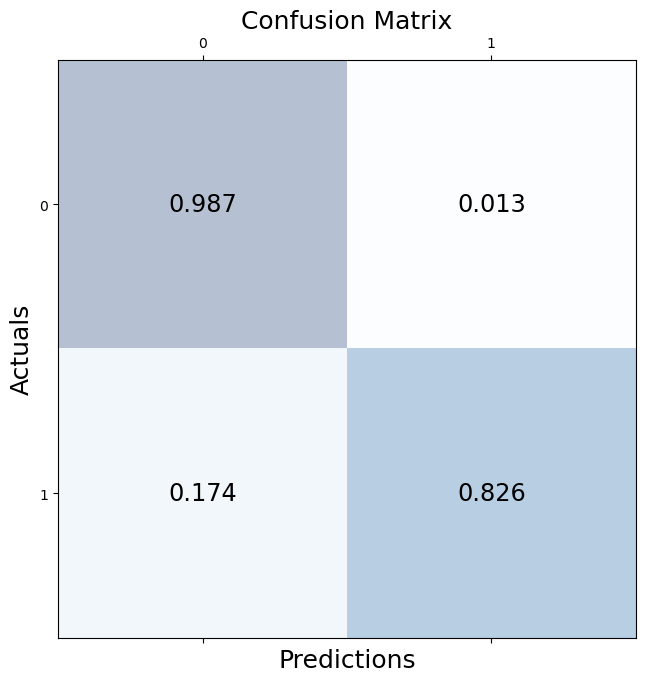

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

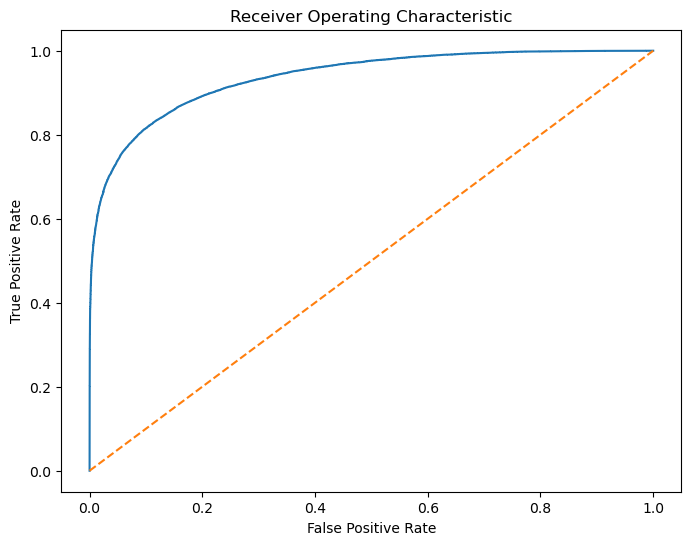

In [ ]:
from sklearn.metrics import roc_curve

fp_rate, tp_rate, threshold = roc_curve((node_labels !=0).astype(float), probas[:, 1])

plt.subplots(1, figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fp_rate, tp_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
probas[:, 1].shape, node_labels

((59904,), array([12.,  0.,  0., ..., 27.,  0.,  0.], dtype=float32))

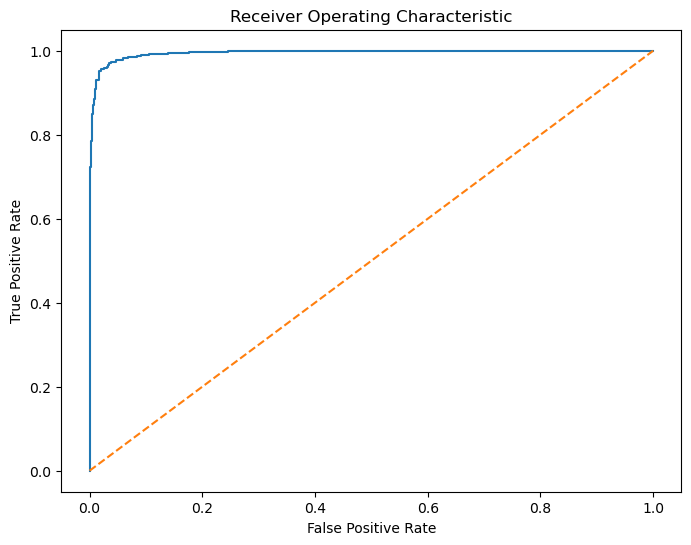

In [ ]:
from sklearn.metrics import roc_auc_score

def hits_score(n_hits, probas, labels):
    sg_indices = node_labels.ravel() == n_hits
    sg_probas = probas[:, 1][sg_indices]
    sg_labels = labels[sg_indices]

    bg_labels = labels[labels == 0]
    bg_probas = probas[:, 1][labels == 0]
    bg_indices = np.random.choice(
        np.arange(len(bg_labels)), size=len(sg_labels)
    )
    bg_labels = bg_labels[bg_indices]
    bg_probas = bg_probas[bg_indices]

    sample_labels = np.hstack((sg_labels, bg_labels))
    sample_probas = np.hstack((sg_probas, bg_probas))
    return sample_labels, sample_probas

def hits_roc_curve(n_hits, probas, labels):
    sample_labels, sample_probas = hits_score(n_hits, probas, labels)
    return roc_curve(sample_labels, sample_probas)

def hits_auc_score(n_hits, probas, labels):
    sample_labels, sample_probas = hits_score(n_hits, probas, labels)
    return roc_auc_score(sample_labels, sample_probas)

fp_rate, tp_rate, _ = hits_roc_curve(30, probas, (node_labels!=0).astype(float))

def plot_roc(fp_rate, tp_rate):
    plt.subplots(1, figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp_rate, tp_rate)
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc(fp_rate, tp_rate)

In [ ]:
import pickle

hits_rates = {}
for n_hits in range(10, 50):
    fp_rate, tp_rate, _ = hits_roc_curve(n_hits, probas, (node_labels !=0).astype(float))
    rates = {'fp_rate': fp_rate, 'tp_rate': tp_rate}
    hits_rates[f'n_hits_{n_hits}'] = rates

with open("100_hits_sample_fp_tp_rates.pcl","wb") as f:
    pickle.dump(hits_rates, f)


Text(0.5, 0, 'n hits')

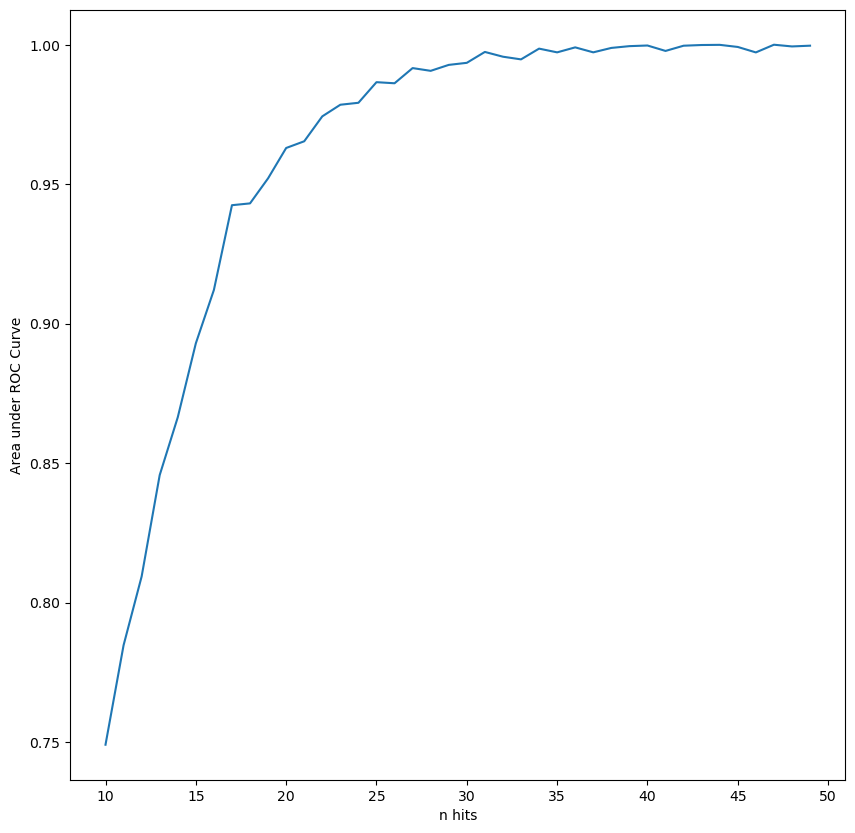

In [ ]:
n_hits = list(range(10, 50))
auc_scores = [hits_auc_score(n, probas, labels) for n in n_hits]
plt.plot(n_hits, auc_scores)
plt.ylabel('Area under ROC Curve')
plt.xlabel('n hits')